In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
pk = lambda k : k**3
pk(3)

27

In [11]:
def pps(k, k_pivot=0.05, A = 1e-9, n_s = 0.965):
    return A * (k / k_pivot)**(n_s - 1)

def pps_run(k, k_pivot=0.05, A = 1e-9, n_s = 0.965, alpha_s = -0.0045):
    return A * (k / k_pivot)**(n_s - 1 + 0.5 * alpha_s * np.log(k / k_pivot))

def PPS_rescale(parm, k_pivot_old, k_pivot_new):
    A_old = parm[0]
    n_s = parm[1]
    log_A_new = np.log(A_old) + (n_s - 1) * np.log(k_pivot_new / k_pivot_old)
    return np.array([np.exp(log_A_new), n_s])

def PPS_run_rescale(parm, k_pivot_old, k_pivot_new):
    A_old = parm[0]
    n_s_old = parm[1]
    alpha_s = parm[2]
    k_ratio = np.log(k_pivot_new / k_pivot_old)
    n_s_new = n_s_old + alpha_s * k_ratio
    log_A_new = np.log(A_old) + (n_s_old - 1) * k_ratio + alpha_s * 0.5 * k_ratio**2

    return np.array([np.exp(log_A_new), n_s_new, alpha_s])


<Figure size 1000x600 with 0 Axes>

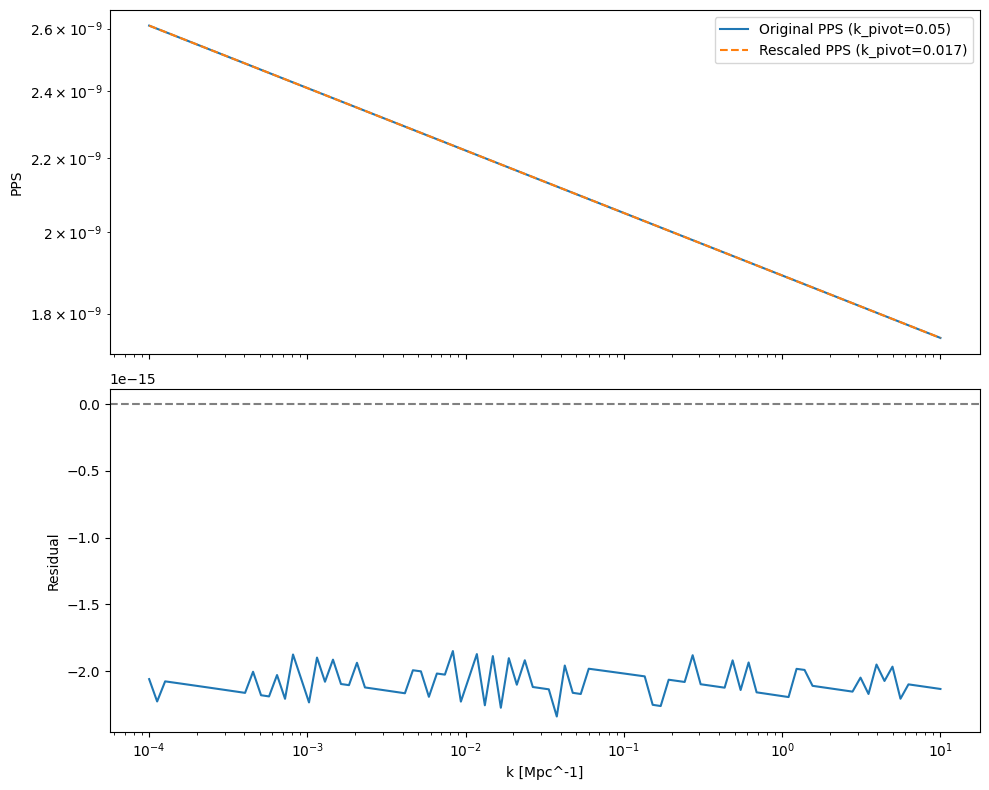

In [12]:
karr = np.logspace(-4, 1, 100)
pps_parm = np.array([2.1e-9, 0.965])

pk_old = pps(karr, k_pivot=0.05, A=pps_parm[0], n_s=pps_parm[1])
pps_new_parm = PPS_rescale(pps_parm, k_pivot_old=0.05, k_pivot_new = 0.017)
pk_new = pps(karr, k_pivot=0.017, A=pps_new_parm[0], n_s=pps_new_parm[1])
pk_new = pps(karr, k_pivot=0.017, A=pps_new_parm[0], n_s=pps_new_parm[1])
residual = (pk_new - pk_old) / pk_old
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].loglog(karr, pk_old, label='Original PPS (k_pivot=0.05)')
ax[0].loglog(karr, pk_new, linestyle='--', label='Rescaled PPS (k_pivot=0.017)')
ax[0].set_ylabel('PPS')
ax[0].legend()
ax[1].semilogx(karr, residual)
ax[1].set_xlabel('k [Mpc^-1]')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show() 


<Figure size 1000x600 with 0 Axes>

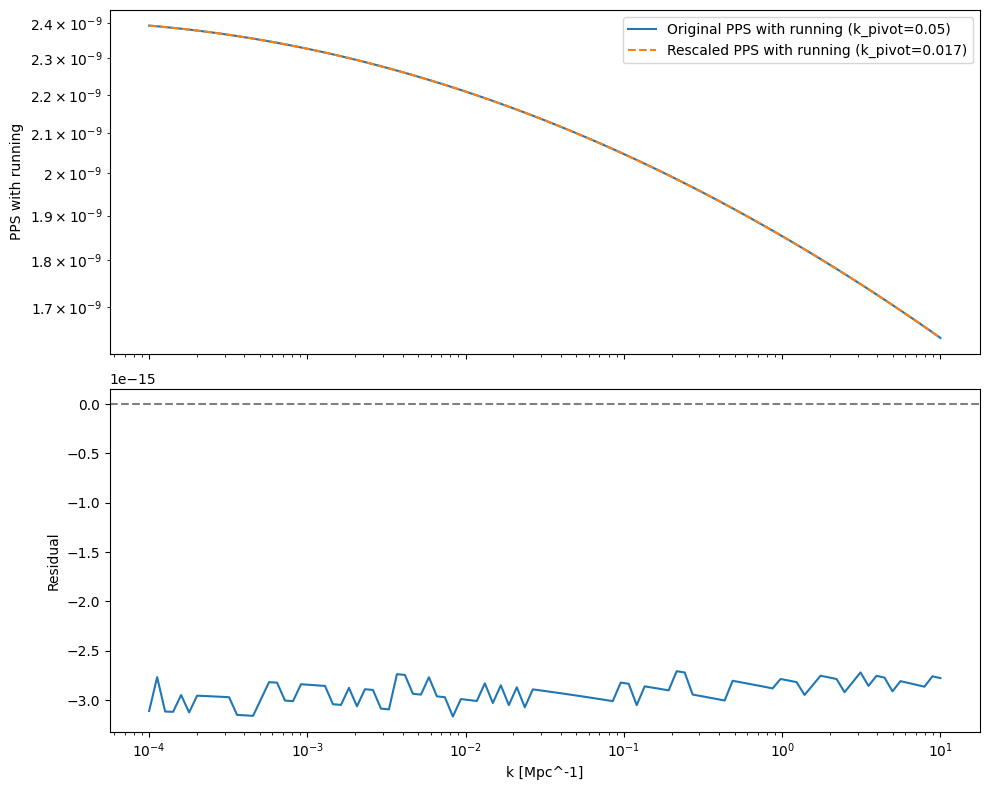

In [13]:
karr = np.logspace(-4, 1, 100)
pps_run_parm = np.array([2.1e-9, 0.965, -0.0045])
pk_run_old = pps_run(karr, k_pivot=0.05, A=pps_run_parm[0], n_s=pps_run_parm[1], alpha_s=pps_run_parm[2])
pps_run_new_parm = PPS_run_rescale(pps_run_parm, k_pivot_old=0.05, k_pivot_new = 0.017)
pk_run_new = pps_run(karr, k_pivot=0.017, A=pps_run_new_parm[0], n_s=pps_run_new_parm[1], alpha_s=pps_run_new_parm[2])
residual_run = (pk_run_new - pk_run_old) / pk_run_old
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
ax[0].loglog(karr, pk_run_old, label='Original PPS with running (k_pivot=0.05)')
ax[0].loglog(karr, pk_run_new, linestyle='--', label='Rescaled PPS with running (k_pivot=0.017)')
ax[0].set_ylabel('PPS with running')
ax[0].legend()
ax[1].semilogx(karr, residual_run)
ax[1].set_xlabel('k [Mpc^-1]')
ax[1].set_ylabel('Residual')
ax[1].axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()